### Setup

In [1]:
import os
import osmnx as ox
import networkx as nx
from graph_search import *
import networkx as nx

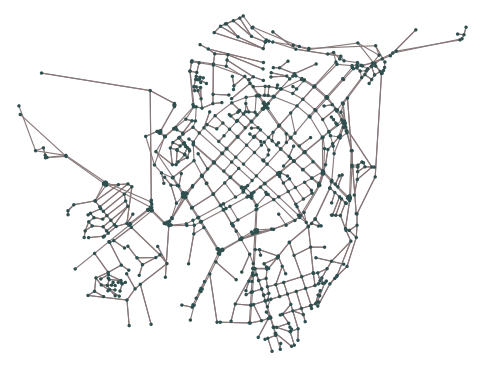

In [2]:
# ----- Build toy MultiGraph -----
PLACE = "Kentron, Yerevan, Armenia"   # small; fast for smoke tests
NETWORK = "drive"

# ---------- download (simplify=True by default here) ----------
G = ox.graph.graph_from_place(PLACE, network_type=NETWORK, simplify=True)

# keep only the largest connected component (weak is fine for roads)
G = ox.truncate.largest_component(G, strongly=False)

keep_node = {"x", "y", "street_count"}
keep_edge = {"length", "highway", "name", "maxspeed"}

for _, d in G.nodes(data=True):
    for k in list(d.keys()):
        if k not in keep_node:
            d.pop(k, None)

for u, v, k, d in G.edges(keys=True, data=True):
    for kk in list(d.keys()):
        if kk not in keep_edge:
            d.pop(kk, None)
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

### A* Search

In [3]:
# Pick valid start and goal nodes
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]

initial = GraphState(G, start_node_id)
goal_test = SimpleGoalTest(goal_node_id)

# Build heuristic h(state)
h = build_euclidean_heuristic(G, goal_node_id)

# Run A* graph search
astar = AStarGraphSearch()
solution_astar = astar.find_solution(initial, goal_test, h)

In [4]:
# ----- Print path -----
if solution_astar:
    path = extract_node_id_path(solution_astar)

    print("Solution path:", path)
    print("Total cost (meters):", solution_astar.path_cost)
    print("Nodes expanded:", astar.get_expanded_node_count())
else:
    print("No solution found.")

Solution path: [256031437, 5026483106, 5026483105, 5009318171, 10831681874, 1475774820, 1807998351, 5118314365, 10831688447, 8913362246, 5035725114, 5026483107, 9280261372, 5489385514, 9227012882, 5489385511, 5450648349, 4296905827, 12593950281, 10970452605, 407729613, 632031882, 6277581589, 2420195983, 6277581586, 6277581587, 3831529185, 11648601295, 11648561414, 11648561419, 11648561420, 11644940327, 11648561426, 11648561428, 407729599, 1970926499, 4110471701, 4110471700, 4234582615]
Total cost (meters): 3593.7360494207596
Nodes expanded: 117


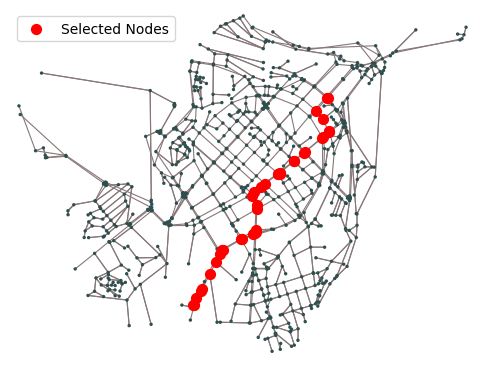

In [5]:
x_coords = [G.nodes[n]["x"] for n in path if n in G.nodes]
y_coords = [G.nodes[n]["y"] for n in path if n in G.nodes]

# replot with highlight
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

# plot the chosen nodes in red
ax.scatter(x_coords, y_coords, c="red", s=50, zorder=5, label="Selected Nodes")
ax.legend()

### Bidirectional Search

In [6]:
# Pick valid start and goal nodes
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]

initial = GraphState(G, start_node_id)
goal_test = SimpleGoalTest(goal_node_id)

# Run Bidirectional graph search
bidirectional = BidirectionalGraphSearch()
solution_bidirectional = bidirectional.find_solution(initial, goal_test)

In [7]:
# ----- Print path -----
if solution_bidirectional:
    path = extract_node_id_path(solution_bidirectional)
    print("Solution path:", path)
    print("Total cost (meters):", solution_bidirectional.path_cost)
    print("Nodes expanded:", bidirectional.get_expanded_node_count())
else:
    print("No solution found.")

Solution path: [256031437, 5026483106, 5026483105, 5009318171, 10831681874, 1475774820, 1807998351, 5118314365, 10831688447, 8913362246, 5035725114, 5026483107, 9280261372, 5489385514, 9227012882, 5489385511, 5450648349, 4296905827, 12593950281, 10970452605, 407729613, 632031882, 6277581589, 2420195983, 6277581586, 6277581587, 3831529185, 11648601295, 11648561414, 11648561419, 11648561420, 11644940327, 11648561426, 11648561428, 407729599, 1970926499, 4110471701, 4110471700, 4234582615]
Total cost (meters): 3593.7360494207596
Nodes expanded: 1400


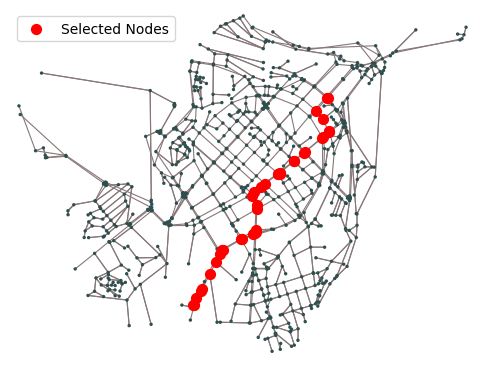

In [8]:
x_coords = [G.nodes[n]["x"] for n in path if n in G.nodes]
y_coords = [G.nodes[n]["y"] for n in path if n in G.nodes]

# replot with highlight
fig, ax = ox.plot.plot_graph(
    G,
    figsize=(6, 6),
    bgcolor="white",
    node_color="#2f4f4f",
    node_size=6,
    edge_color="#877778",
    edge_linewidth=0.8,
    show=False,
    close=False,
)

# plot the chosen nodes in red
ax.scatter(x_coords, y_coords, c="red", s=50, zorder=5, label="Selected Nodes")
ax.legend()

### DLitteSearch

In [9]:
def plot_graph_with_path(
    G,
    path,
    node_color="red",
    edge_color="red",
    blocked_edges=None,
    blocked_color="orange",
    blocked_width=3
):
    """
    G             : OSMnx/NetworkX graph
    path          : list of node IDs representing the selected path
    blocked_edges : set of (u, v) pairs (order does not matter)
    blocked_color : color for blocked edges
    blocked_width : linewidth for blocked edges
    """

    # --- 1) Base graph plot ---
    fig, ax = ox.plot.plot_graph(
        G,
        figsize=(6, 6),
        bgcolor="white",
        node_color="#2f4f4f",
        node_size=6,
        edge_color="#877778",
        edge_linewidth=0.8,
        show=False,
        close=False,
    )

    # --- 2) Plot path nodes ---
    x_coords = [G.nodes[n]["x"] for n in path]
    y_coords = [G.nodes[n]["y"] for n in path]
    ax.scatter(x_coords, y_coords, c=node_color, s=50, zorder=6)

    # --- 3) Plot path edges ---
    ax.plot(x_coords, y_coords, color=edge_color, linewidth=3, zorder=5)

    # --- 4) Plot blocked edges ---
    if blocked_edges:
        # Make blocked_edges order-insensitive
        blocked_set = {(u, v) for u, v in blocked_edges} | {(v, u) for u, v in blocked_edges}

        for u, v, data in G.edges(keys=False, data=True):
            if (u, v) in blocked_set:
                # If the edge has geometry, draw it accurately
                if "geometry" in data:
                    xs, ys = data["geometry"].xy
                else:
                    xs = [G.nodes[u]["x"], G.nodes[v]["x"]]
                    ys = [G.nodes[u]["y"], G.nodes[v]["y"]]

                ax.plot(
                    xs,
                    ys,
                    color=blocked_color,
                    linewidth=blocked_width,
                    alpha=0.9,
                    zorder=7,
                )

    return fig, ax


In [11]:
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]
dlit = DStarSearch(G, start_node_id, goal_node_id, edge_cost_changer=EdgeCostChanger(G)) #no edge cost occurs
path, chaned_edge_list = dlit.main()  #change edge list will return none as no edge is beign changed

Path Cost: 3593.7360494207596


(<Figure size 600x600 with 1 Axes>, <Axes: >)

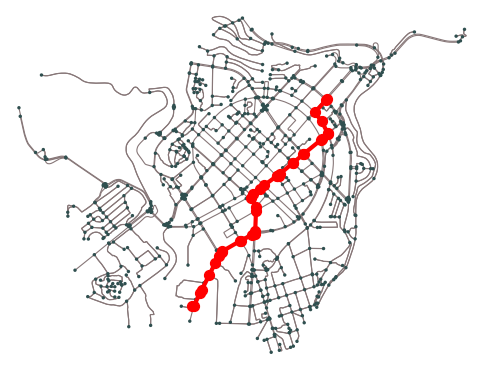

In [12]:
plot_graph_with_path(G, path)


In [ ]:
## node is being blocked

In [13]:
node_to_block = path[16]

In [15]:
scheduler = EdgeCostChanger(G, node_to_block, time_to_block=5, factor=100)

In [16]:
start_node_id = list(G.nodes)[0]
goal_node_id = list(G.nodes)[564]
dlit = DStarSearch(G, start_node_id, goal_node_id, edge_cost_changer=scheduler) #no edge cost occurs
path, chaned_edge_list = dlit.main()  #change edge list will return none as no edge is beign changed

Path Cost: 3629.7238109605914


(<Figure size 600x600 with 1 Axes>, <Axes: >)

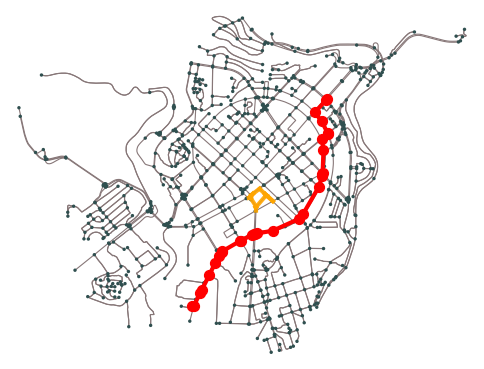

In [17]:
plot_graph_with_path(G, path, blocked_edges=chaned_edge_list)